# cart and pole problem

###### No optimization and no instructions for when to end an episode

In [3]:
!pip install pyglet

In [2]:
#!pip install collections
!pip install torch

ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


In [1]:
import gym
env=gym.make('CartPole-v1')
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample())
    
env.close()

C:\Users\Personal\Anaconda3\lib\site-packages\gym\envs\classic_control\cartpole.py:151: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  "You are calling 'step()' even though this "


In [2]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

## Set up display

In [3]:
is_ipython='inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

## Deep Q-Network class

In [4]:
#The DQN class is a class that extends the nn.module.
#The DQN will recieve screen shot like images of the cart n pole environment as inputs.
class DQN(nn.Module):
    #the DQN object will require the height and width of the image input that will be passed to the model
    def __init__(self,img_height,img_width):
        super().__init__()
        
        self.fc1= nn.Linear(in_features=img_height*img_width*3, out_features=24)
        self.fc2= nn.Linear(in_features=24, out_features=32)
        self.out= nn.Linear(in_features=32, out_features=2)
    # this is he last thing to do for this DQN class
    # defining a function called forward to implement a forward pass 
    def forward(self,t):
        t= t.flatten(start_dim=1)
        t= F.relu(self.fc1(t))
        t=F.relu(self.fc2(t))
        t=self.out(t)
        return t
        

## Experience Class

In [5]:
Experience = namedtuple(
          'Experience',                   
           ('state','action','next_state', 'reward')
)

## Replay Memory

In [6]:
class ReplayMemory():
    def __init__(self,capacity):
        self.capacity=capacity
        self.memory=[]
        self.push_count=0
        
     # this is responsible for storing experiences   
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity]=experience
        self.push_count +=1
        
    # this function takes sample of batch_size from the replay memory    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    # this funcion checks if the xperiences in replay memory are enough to be sampled
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

## Epsilon Greedy Strategy

In [15]:
class EpsilonGreedyStrategy():
    def __init__(self,start, end, decay):
        self.start= start
        self.end= end
        self.decay= decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end)* \
                math.exp(-1.* current_step * self.decay)
    

## Reinforcement Learning Agent

In [111]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step=0
        self.strategy= strategy
        self.num_actions= num_actions
        self.device= device
        
    def select_action(self, state, policy_net):
        rate= strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
            action=random.randrange(self.num_actions) # explore
            return torch.tensor([action]).to(device)
            
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(device) #exploit
            

## Environment Manager

In [9]:
class CartPoleEnvManager():
    def __init__(self,device):
        self.device =device
        self.env= gym.make('CartPole-v1').unwrapped
        self.env.reset()
        self.current_screen=None
        self.done=False
        
    def reset(self):
        self.env.reset()
        self.current_screen=None
        
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device= self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1=self.current_screen
            s2=self.get_processed_screen()
            self.current_screen=s2
            return s2-s1
        
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen= self.render('rgb_array').transpose((2,0,1))
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        # strip off top and bottom
        top= int(screen_height*0.4)
        bottom= int(screen_height*0.8)
        screen= screen[:,top:bottom,:]
        return screen
    
    def transform_screen_data(self,screen):
        #convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen,dtype=np.float32)/255
        screen = torch.from_numpy(screen)
        
        # use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage(),
            T.Resize((40,90)),
            T.ToTensor()
        ])
        # the extra dimension added by the unsqueeze method represents a batch dimension 
        #since the inputs required in the DQN are in batches
        return resize(screen).unsqueeze(0).to(self.device) #

## Example of non-processed screen

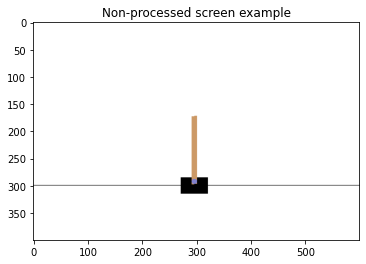

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
em= CartPoleEnvManager(device)
em.reset()
screen= em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

## Example of processed screen

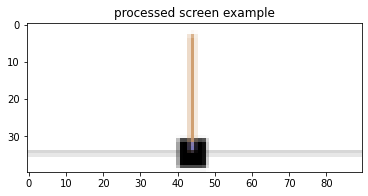

In [40]:
screen = em.get_processed_screen()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation='none')
plt.title('processed screen example')
plt.show()

## Example of starting state

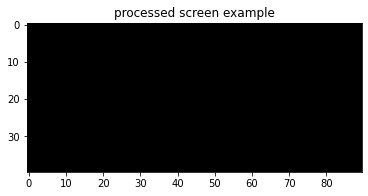

In [41]:
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation='none')
plt.title('processed screen example')
plt.show()

## Example of non-starting state

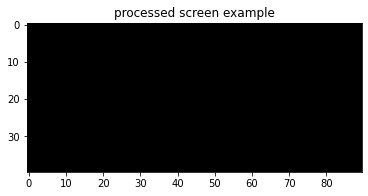

In [44]:
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation='none')
plt.title('processed screen example')
plt.show()

## Example of end state

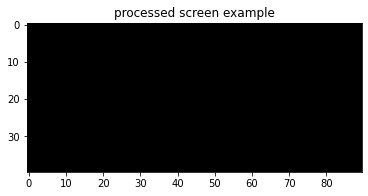

In [45]:
em.done=True
screen=em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation='none')
plt.title('processed screen example')
plt.show()

## Utility functions

### Plotting

In [105]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    
    moving_avg=get_moving_average(moving_avg_period,values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print('Episode', len(values), '\n', \
          moving_avg_period, 'episode moving avg:', moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)
        
def get_moving_average(period,values):
    values= torch.tensor(values,dtype=torch.float)
    if len(values)>=period:
        moving_avg= values.unfold(dimension=0, size= period, step=1)\
        .mean(dim=1).flatten(start_dim=0)
        moving_avg= torch.cat((torch.zeros(period-1),moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg= torch.zeros(len(values))
        return moving_avg.numpy()

In [106]:
r=torch.tensor([3,4,5,6,7])

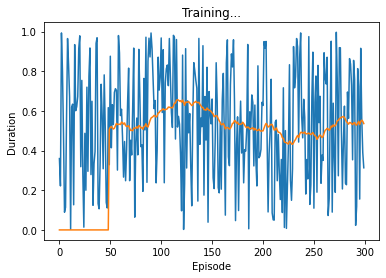

Episode 300 
 50 episode moving avg: 0.5362368


In [107]:
plot(np.random.rand(300),50)

### Tensor Processing

In [65]:
def extract_tensors(experiences):
    
    batch= Experience(*zip(*experiences))
    
    t1= torch.cat(batch.state)
    t2= torch.cat(batch.action)
    t3= torch.cat(batch.reward)
    t4= torch.cat(batch.next_state)
    
    return (t1,t2,t3,t4)


## Q-value class

In [94]:
class QValues():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index= actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations= next_states.flatten(start_dim=1)\
             .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations= (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations]= target_net(non_final_states).max(dim=1)[0].detach()
        return values
    

# Main Program

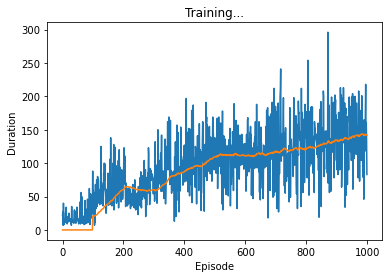

Episode 1000 
 100 episode moving avg: 142.01


In [112]:
batch_size =256
gamma =0.999
eps_start= 1
eps_end =0.01
eps_decay=0.001
target_update=10
memory_size=100000
lr=0.001
num_episodes=1000

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
em=CartPoleEnvManager(device)
strategy= EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent= Agent(strategy,em.num_actions_available(),device)
memory= ReplayMemory(memory_size)

policy_net= DQN(em.get_screen_height(),em.get_screen_width()).to(device)
target_net= DQN(em.get_screen_height(),em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_durations=[]
for episode in range(num_episodes):
    em.reset()
    state=em.get_state()
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward= em.take_action(action)
        next_state= em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state= next_state
        
        if memory.can_provide_sample(batch_size):
            experiences= memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values= (next_q_values*gamma)+ rewards
            
            loss= F.mse_loss(current_q_values,target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations,100)
            break
            
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
em.close()




In [27]:
x=Experience(2,3,4,5)
y=Experience(6,7,8,9)

In [60]:
t=Experience(*zip(*[x,y]))

In [100]:
t = torch.tensor([[1,2,3,4]])